# Simulated/"hybrid" Motion

In [1]:
from matplotlib import pyplot as plt
import numpy as np

def plot_auc_CDF(aucs):
    """Plot the cumulative dist function (CDF) of the AUCs."""
    # plt.figure(figsize=(20, 10))
    plt.xlim(0, 1)
    _ = plt.hist(aucs,
                cumulative=True,
                density=True,
                bins=100)


def plot_auc_PDF(aucs):
    """Plot the probability dist function (PDF) of the AUCs."""
    plt.xlim(0, 1)
    plt.hist(aucs, bins=20)

    # plot the mean as a vertical 'tab:orange' line
    plt.axvline(np.mean(aucs), color='tab:orange', linestyle='--', label=f"Mean: {np.mean(aucs):.3f}")
    plt.legend()

### Comparison: TST, WASA93

* TST: Total Sleep Time
* WASA93: <u>W</u>ake <u>A</u>ccuracy when <u>S</u>leep <u>A</u>ccuracy is fixed at <u>93%</u>

In [15]:
from pisces.utils import SleepMetricsCalculator, pad_to_hat
from sklearn.metrics import roc_auc_score, roc_curve


def split_analysis(y, y_hat_sleep_proba, sleep_accuracy: float = 0.93):

    y_flat = y.reshape(-1,)
    n_sleep = np.sum(y_flat > 0)
    n_wake = np.sum(y_flat == 0)
    N = n_sleep + n_wake

    balancing_weights_ignore_mask = np.where(y_flat > 0, N / n_sleep, N / n_wake)
    balancing_weights_ignore_mask /= np.sum(balancing_weights_ignore_mask) # sums to 1.0

    # adjust y to match the lenght of y_hat, which was padded to fit model constraints
    y_padded = pad_to_hat(y, y_hat_sleep_proba)
    # make a mask to ignore the padded values, so they aren't counted against us
    mask = pad_to_hat(balancing_weights_ignore_mask, y_hat_sleep_proba)
    # mask = pad_to_hat(y_flat, y_hat_sleep_proba)

    # also ignore any unscored or missing values.
    y_to_use = y_padded >= 0
    mask *= y_to_use
    # roc_auc will complain if -1 is in y_padded
    y_padded *= y_to_use 

    # ROC analysis
    this_auc = roc_auc_score(y_padded, y_hat_sleep_proba, sample_weight=mask)
    fprs, tprs, thresholds = roc_curve(y_padded, y_hat_sleep_proba, sample_weight=mask)

    # WASA X requires the largest such that the FPR is < than 1 - sleep_accuracy
    # so that sleep accuracy (1 - FPR) is >= sleep_accuracy
    wasa_threshold = thresholds[np.sum(fprs < 1 - sleep_accuracy)]
    y_guess = y_hat_sleep_proba > wasa_threshold

    # WASA X
    guess_right = y_guess == y_padded
    sleep_accuracy = np.sum(guess_right * y_to_use) / np.sum(y_to_use)
     
    return {
        "y_padded": y_padded,
        "y_hat": y_hat_sleep_proba,
        "mask": mask,
        "auc": this_auc,
        "roc_curve": {"tprs": tprs,
                      "fprs": fprs,
                      "thresholds": thresholds
        }, 
        f"wasa{sleep_accuracy}_threshold": wasa_threshold,
        f"wasa{sleep_accuracy}": sleep_accuracy, 
    }


In [3]:
#| export

from typing import List

from pisces.utils import avg_steps
from sklearn.metrics import auc as auc_score

def add_rocs(fprs: List[np.ndarray],
             tprs: List[np.ndarray],
             x_class: str = "SLEEP",
             y_class: str = "WAKE", 
             min_auc: float = 0.0,
             avg_curve_color: str = "tab:blue",
             specific_curve_color: str = "tab:orange",
             roc_group_name: str = "", ax: plt.Axes | None = None):
    """
    Adds ROC curves to the given plot, or makes a new plot if ax is None.

    if ax is None, we are making a new plot. We do additional formatting
    in this case, such as adding the legend and showing the plot. 
    
    When `ax` is provided, we expect the call site to do formatting.
    """
    # don't overwrite ax, this lets us use the None info later on 
    # to automatically show the legend and do other formatting, 
    # which otherwise we'd expect the call site to peform on `ax`
    resolved_ax = ax if ax is not None else plt.subplots()[1]
    aucs = np.array([
        auc_score(fpr, tpr)
        for fpr, tpr in zip(fprs, tprs)
    ])

    all_fprs, avg_curve = avg_steps(
            xs=[list(fprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
            ys=[list(tprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
        )

    avg_auc = np.mean(aucs[aucs > min_auc])

    resolved_ax.step(
        all_fprs,
        avg_curve,
        c=avg_curve_color,
        where="post",
        label=f"{roc_group_name + ' ' * bool(roc_group_name)}All splits avg ROC-AUC: {avg_auc:0.3f}",
    )
    for roc in zip(fprs, tprs):
        resolved_ax.step(roc[0], roc[1], c=specific_curve_color, alpha=0.2, where="post")
    resolved_ax.plot([0, 1], [0, 1], "-.", c="black")

    resolved_ax.set_ylabel(f"Fraction of {y_class} scored as {y_class}")
    resolved_ax.set_xlabel(f"Fraction of {x_class} scored as {y_class}")

    resolved_ax.spines["top"].set_visible(False)
    resolved_ax.spines["right"].set_visible(False)

    if ax is None:
        # show the legend if we are making a new plot
        # otherwise, the call site might want to make their own legend, leave it.
        resolved_ax.legend()
        plt.show()

In [4]:
import matplotlib.pyplot as plt
from pisces.experiments import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [5]:
from pisces.experiments import MOResUNetPretrained


mo = MOResUNetPretrained(sampling_hz=32)



In [6]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
DATA_SET = walch

mo_preprocessed_data_walch = [
    (d, i) 
    for (d, i) in zip(
        mo.prepare_set_for_training(DATA_SET, DATA_SET.ids),
        DATA_SET.ids) 
    if d is not None
]

evaluations_walch: List[dict] = []
for i, ((X, y), id) in enumerate(mo_preprocessed_data_walch):
    y_hat_proba = mo.predict_probabilities(X)
    y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
    analysis = split_analysis(y, y_hat_sleep_proba)
    evaluations_walch.append(analysis)
    print(f"Processing {i+1} of {len(mo_preprocessed_data_walch)} ({id})... AUROC: {analysis['auc']}")
mo_aucs_walch = [e["auc"] for e in evaluations_walch]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch]


getting needed X, y for 1066528
getting needed X, y for 1449548
sampling hz: 32
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
getting needed X, y for 1360686
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01986s)
sampling hz: 32
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
getting needed X, y for 1455390
getting needed X, y for 2638030
getting needed X, y for 1818471
sampling hz: 32
getting needed X, y for 4314139
getting needed X, y for 3509524
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
sampling hz: 32
sampling hz: 32
sampling hz: 32
resampling to 32Hz (0.03125s) from 66 Hz (0.01501s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01988s)
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01998s)
getting needed X, y for 2598705
getting needed X, y for 46343
getting needed X, y for 4426783
getting needed X, y for 4018081
getting needed X, y for 3997827
getting needed X, y for 5132496
getting ne

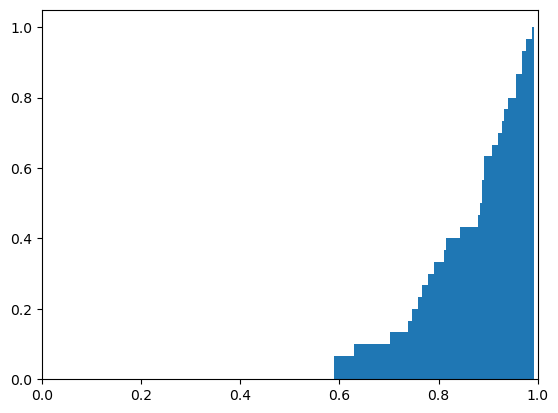

In [7]:

plot_auc_CDF(mo_aucs_walch)

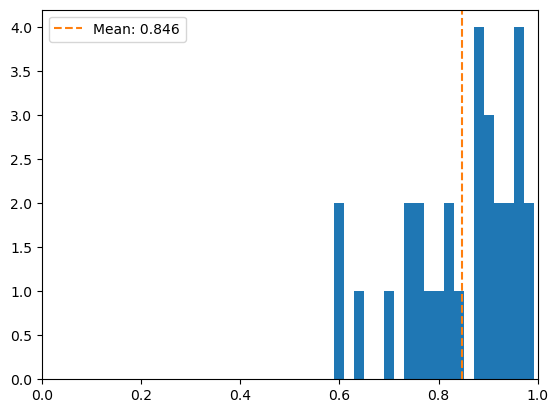

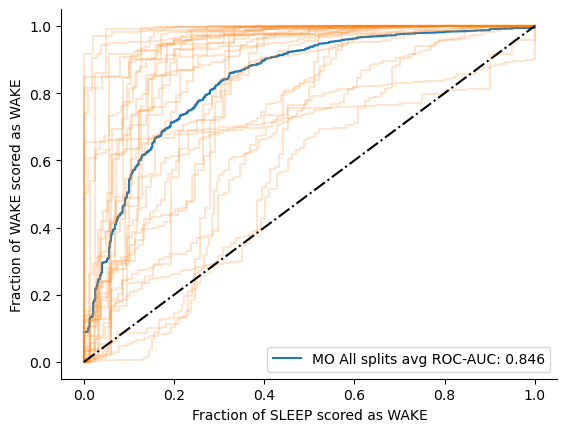

In [8]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones
plot_auc_PDF(mo_aucs_walch)

add_rocs(mo_fprs_walch, mo_tprs_walch, roc_group_name="MO")

### debugging

In [9]:
import random

from pisces.experiments import MOResUNetPretrained


w = sets['walch_et_al']
subj = w.ids[1]
(X, y), id  = mo_preprocessed_data_walch[1]
print("X.shape =", X.shape)
spec = X[0, 1:, :, 0].T

print("spec.shape =", spec.shape)


X.shape = (1, 15360, 32, 2)
spec.shape = (32, 15359)


In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_spectrogram(preprocessed_data, idx):
    (X, y), id = preprocessed_data[idx]
    spec = X[0, 1:, :, 0].T

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    # ax1.imshow(.T)

    img = ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
    ax1.set_title('Spectrogram, Time : Freq')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Freq')

    axins = inset_axes(ax1,
                    width="5%",  # width = 5% of parent_bbox width
                    height="75%",  # height : 50%
                    loc='center right')

    plt.colorbar(img, cax=axins, orientation="vertical")

    ax3.plot(spec)
    ax3.set_title('Spectrogram, Frequency : Power ')
    ax3.set_xlabel('Freq')
    ax3.set_ylabel('Power')
    ax3.set_xlim(0, 31)#spec.shape[0])


    ax2.plot(spec.T)
    ax2.set_title('Spectrogram, Time : Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    ax2.set_xlim(0, spec.shape[1])

    plt.tight_layout(pad=0.3)
    fig.suptitle(f"Subject {id}")
    plt.show()


In [11]:

def plot_predictions(evaluations, y_time, idx):
    y_pad = evaluations[idx]["y_padded"][:len(y_time)]
    y_pred = evaluations[idx]["y_hat"][:len(y_time)]
    y_mask = evaluations[idx]["mask"][:len(y_time)]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(y_time, y_pad, label="True")
    ax.plot(y_time, y_pred, label="Predicted")
    ax.plot(y_time, y_mask, label="Mask")
    ax.legend(loc='upper right')

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_11958/3078200158.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


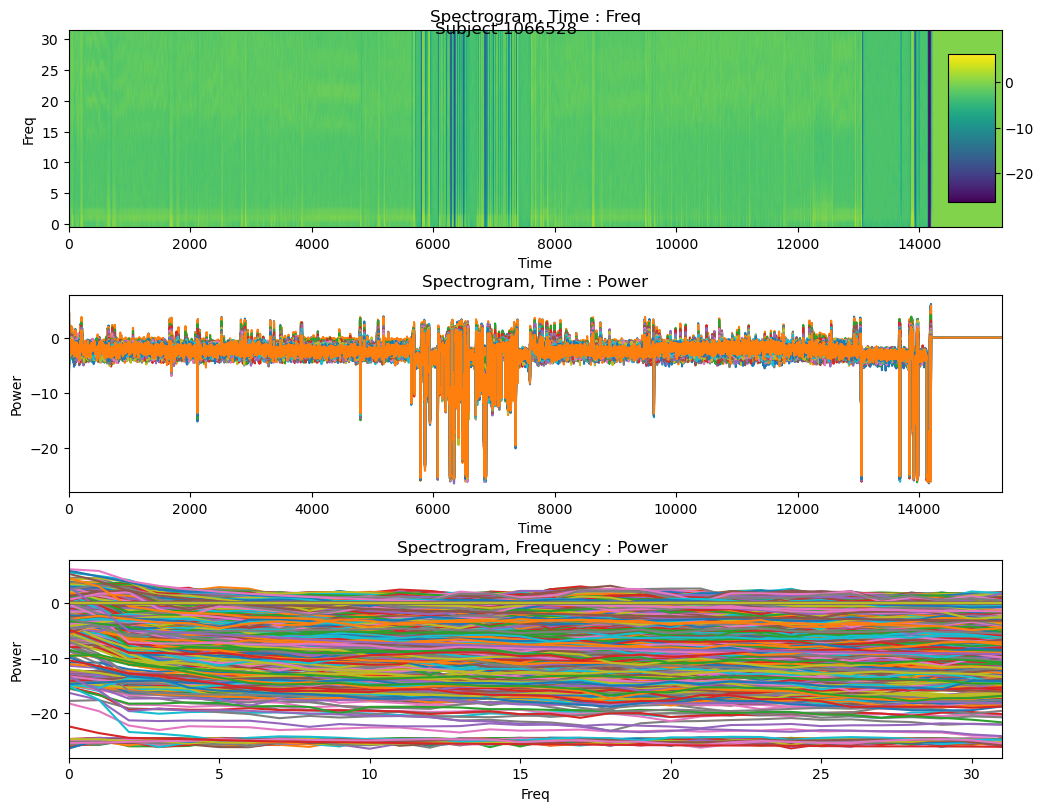

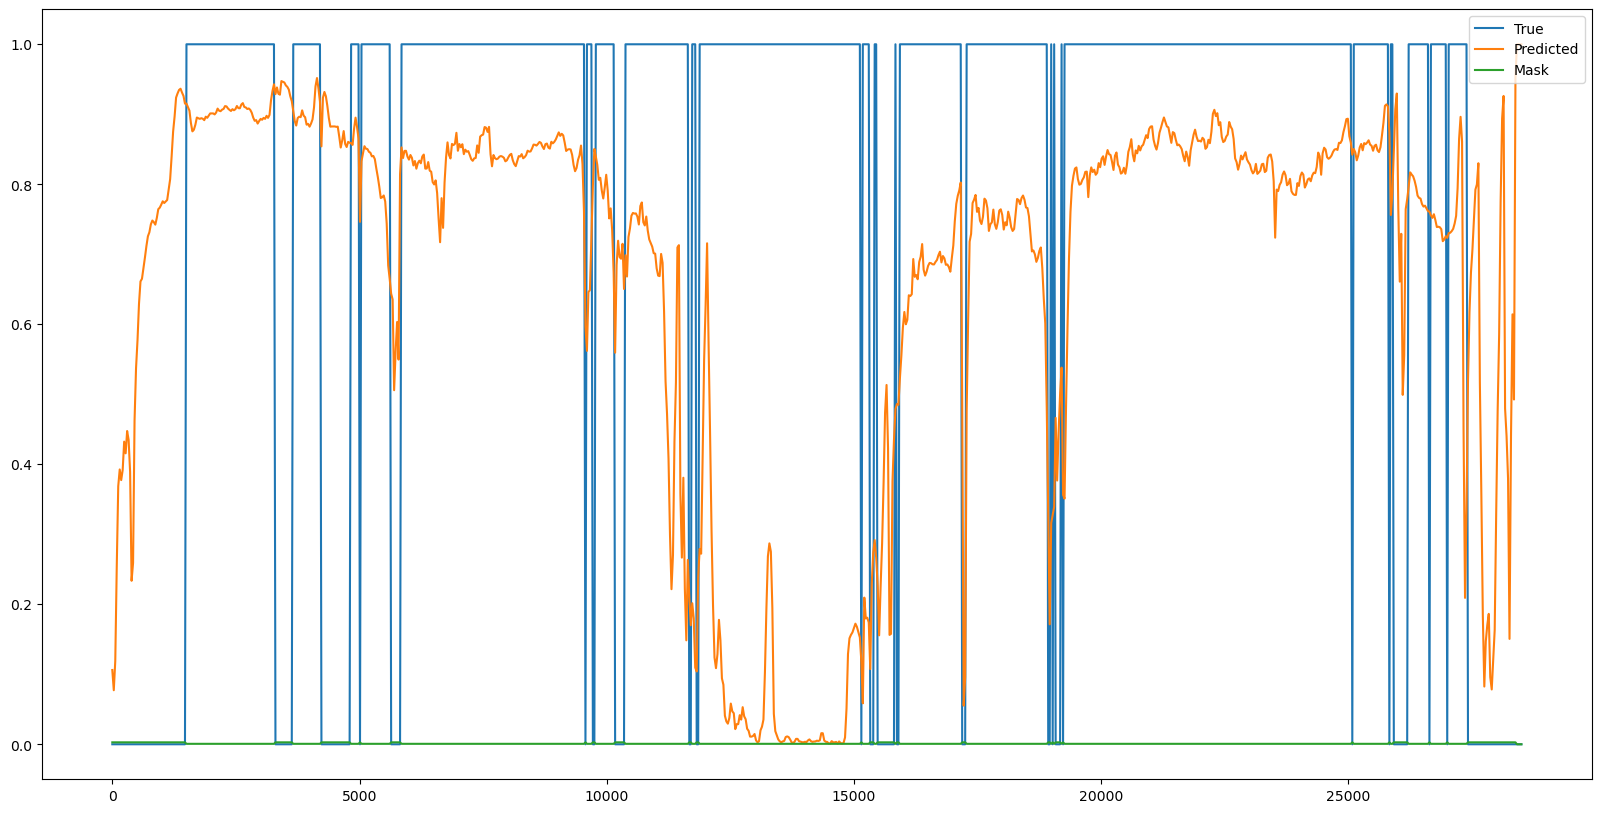

In [12]:
index = 0
psg = w.get_feature_data("psg", w.ids[index])
psg_time = psg[:, 0].to_numpy()

plot_spectrogram(mo_preprocessed_data_walch, index)
plot_predictions(evaluations=evaluations_walch, y_time=psg_time, idx=index)

## LOO + SGD Log Reg classifier
Adding LOOX can be achieved by training on 'walch_et_al' and testing on 'hybrid_data'.

In [13]:

from pisces.experiments import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

DATA_SET = walch
loo = LeaveOneOutSplitter()

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, DATA_SET, SGDLogisticRegression)

ID 7749105 not found in walch_et_al


31it [00:02, 11.10it/s]


In [16]:

log_reg_preprocessed_data_walch = [l for l in log_reg_preprocessed_data_walch if l[0] is not None]
log_reg_evaluations_walch: List[dict] = []
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_walch):
    y_hat_proba = split_models[i].predict_probabilities(X)
    analysis = split_analysis(y, y_hat_sleep_proba)
    log_reg_evaluations_walch.append(analysis)
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_walch)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_walch = [e["auc"] for e in log_reg_evaluations_walch]
log_reg_fprs_walch = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_walch]
log_reg_tprs_walch = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_walch]


Processing 1 of 30 (1066528)... AUROC: 0.6065985803273957
Processing 2 of 30 (1360686)... AUROC: 0.8287667006078562
Processing 3 of 30 (1449548)... AUROC: 0.4301637336719853
Processing 4 of 30 (1455390)... AUROC: 0.5678544092723167
Processing 5 of 30 (1818471)... AUROC: 0.8751054852320685
Processing 6 of 30 (2598705)... AUROC: 0.595824411134906
Processing 7 of 30 (2638030)... AUROC: 0.597107661985717
Processing 8 of 30 (3509524)... AUROC: 0.7751962160195429
Processing 9 of 30 (3997827)... AUROC: 0.8863879957127557
Processing 10 of 30 (4018081)... AUROC: 0.7568615751789946
Processing 11 of 30 (4314139)... AUROC: 0.7315658378960617
Processing 12 of 30 (4426783)... AUROC: 0.7805044790193313
Processing 13 of 30 (46343)... AUROC: 0.7421819474058241
Processing 14 of 30 (5132496)... AUROC: 0.815510089291993
Processing 15 of 30 (5383425)... AUROC: 0.9553074866310154
Processing 16 of 30 (5498603)... AUROC: 0.35136959169002036
Processing 17 of 30 (5797046)... AUROC: 0.42774200203356527
Processin

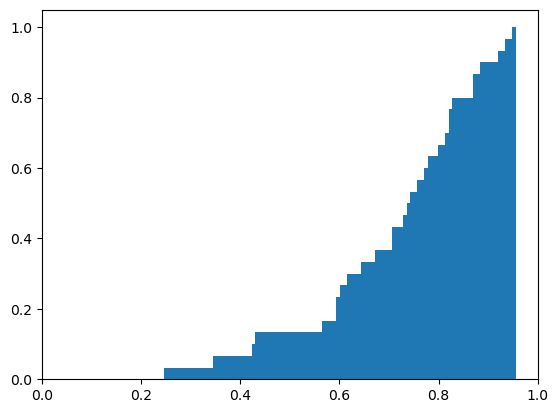

In [17]:
plot_auc_CDF(log_reg_aucs_walch)

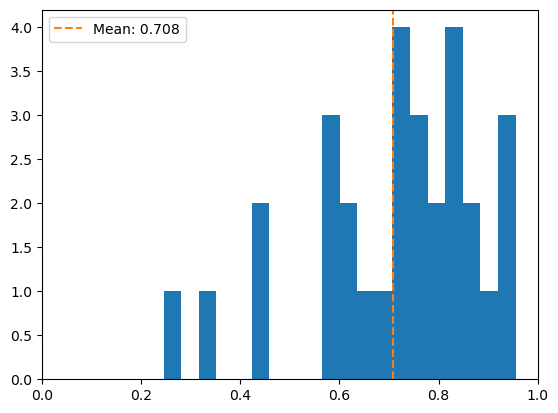

In [18]:
plot_auc_PDF(log_reg_aucs_walch)

### Comparision: ROC

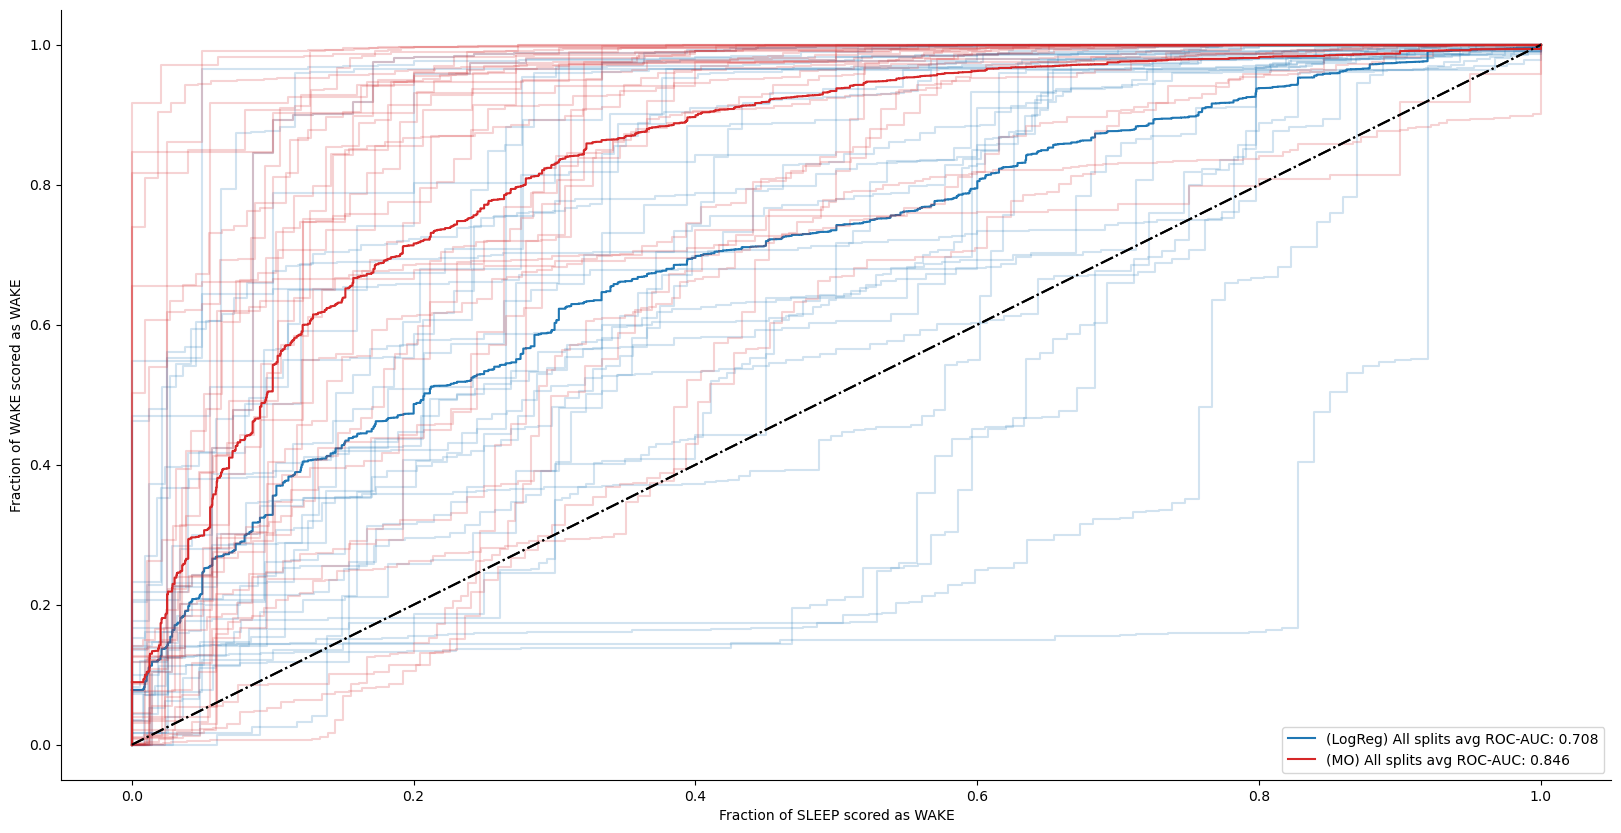

In [19]:


fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    fprs=log_reg_fprs_walch, 
    tprs=log_reg_tprs_walch,
    # min_auc=0.7, 
    avg_curve_color="tab:blue",
    specific_curve_color="tab:blue",
    roc_group_name="(LogReg)",
    ax=ax,
)

add_rocs(
    fprs=mo_fprs_walch,
    tprs=mo_tprs_walch,
    avg_curve_color="tab:red",
    specific_curve_color="tab:red",
    # min_auc=0.7,
    roc_group_name="(MO)",
    ax=ax
)
ax.legend(loc='lower right')

# Hybrid data set

In [20]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
DATA_SET = hybrid

mo_preprocessed_data_hybrid = [
    (d, i) 
    for (d, i) in zip(
        mo.prepare_set_for_training(DATA_SET, DATA_SET.ids),
        DATA_SET.ids) 
    if d is not None
]

evaluations_hybrid: List[dict] = []
for i, ((X, y), id) in enumerate(mo_preprocessed_data_hybrid):
    y_hat_proba = mo.predict_probabilities(X)
    y_hat_sleep_proba = (1 - y_hat_proba[:, :, 0]).reshape(-1,)
    analysis = split_analysis(y, y_hat_sleep_proba)
    evaluations_hybrid.append(analysis)
    print(f"Processing {i+1} of {len(mo_preprocessed_data_hybrid)} ({id})... AUROC: {analysis['auc']}")
mo_aucs_hybrid = [e["auc"] for e in evaluations_hybrid]
mo_fprs_hybrid = [e["roc_curve"]["fprs"] for e in evaluations_hybrid]
mo_tprs_hybrid = [e["roc_curve"]["tprs"] for e in evaluations_hybrid]


getting needed X, y for 1066528
getting needed X, y for 1449548
sampling hz: 32
getting needed X, y for 1360686
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
sampling hz: 32
sampling hz: 32
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01986s)
getting needed X, y for 1818471
getting needed X, y for 2598705
getting needed X, y for 1455390
sampling hz: 32
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
sampling hz: 32
sampling hz: 32
getting needed X, y for 3509524
resampling to 32Hz (0.03125s) from 50 Hz (0.01977s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
sampling hz: 32
resampling to 32Hz (0.03125s) from 66 Hz (0.01501s)
getting needed X, y for 3997827
getting needed X, y for 4314139
getting needed X, y for 2638030
sampling hz: 32
sampling hz: 32
getting needed X, y for 4426783
resampling to 32Hz (0.03125s) from 50 Hz (0.01967s)
resampling to 32Hz (0.03125s) from 50 Hz (0.01998s)
sampling hz: 32
sampling hz: 32
resa

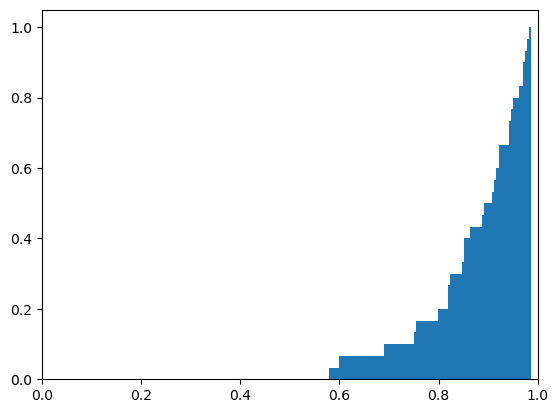

In [21]:

plot_auc_CDF(mo_aucs_hybrid)

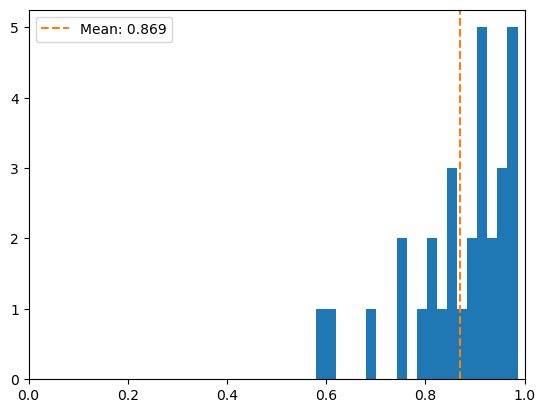

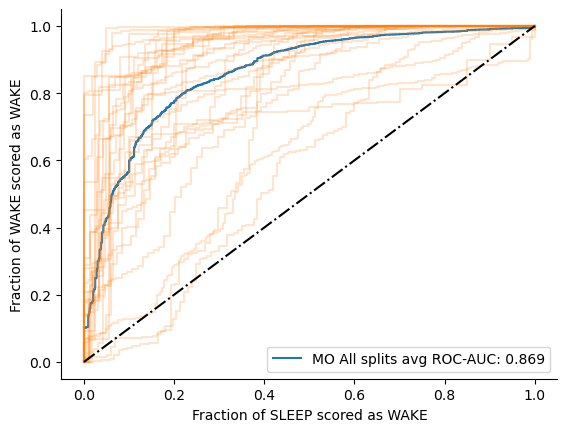

In [22]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones
plot_auc_PDF(mo_aucs_hybrid)

add_rocs(mo_fprs_hybrid, mo_tprs_hybrid, roc_group_name="MO")

In [23]:

log_reg_preprocessed_data_hybrid = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[i].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hybrid: List[dict] = []
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_hybrid):
    y_hat_proba = split_models[i].predict_probabilities(X)
    analysis = split_analysis(y, y_hat_sleep_proba)
    log_reg_evaluations_hybrid.append(analysis)
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_hybrid)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_hybrid = [e["auc"] for e in log_reg_evaluations_hybrid]
log_reg_fprs_hybrid = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_hybrid]
log_reg_tprs_hybrid = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_hybrid]


ID 7749105 not found in hybrid_motion
Processing 1 of 29 (1066528)... AUROC: 0.6061594841255862
Processing 2 of 29 (1360686)... AUROC: 0.808463698355398
Processing 3 of 29 (1449548)... AUROC: 0.4365959119496878
Processing 4 of 29 (1455390)... AUROC: 0.5350445574326245
Processing 5 of 29 (1818471)... AUROC: 0.8698312236286957
Processing 6 of 29 (2598705)... AUROC: 0.5895610278372623
Processing 7 of 29 (2638030)... AUROC: 0.5731362404533166
Processing 8 of 29 (3509524)... AUROC: 0.7448165042504665
Processing 9 of 29 (3997827)... AUROC: 0.9043086816720274
Processing 10 of 29 (4018081)... AUROC: 0.69810380550237
Processing 11 of 29 (4314139)... AUROC: 0.784927295574904
Processing 12 of 29 (4426783)... AUROC: 0.7579513343799056
Processing 13 of 29 (46343)... AUROC: 0.7995735607675906
Processing 14 of 29 (5132496)... AUROC: 0.7998035914702591
Processing 15 of 29 (5383425)... AUROC: 0.9544471153846156
Processing 16 of 29 (5498603)... AUROC: 0.2959697178655809
Processing 17 of 29 (5797046)... 

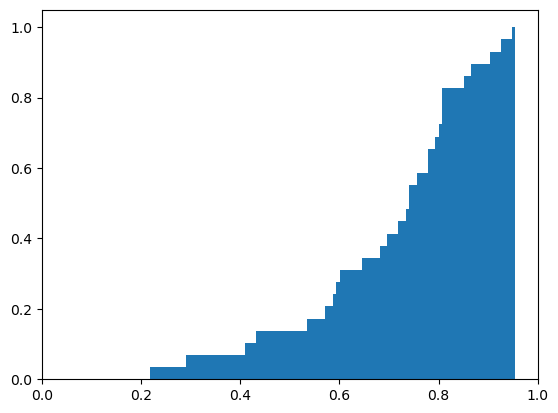

In [24]:


plot_auc_CDF(log_reg_aucs_hybrid)

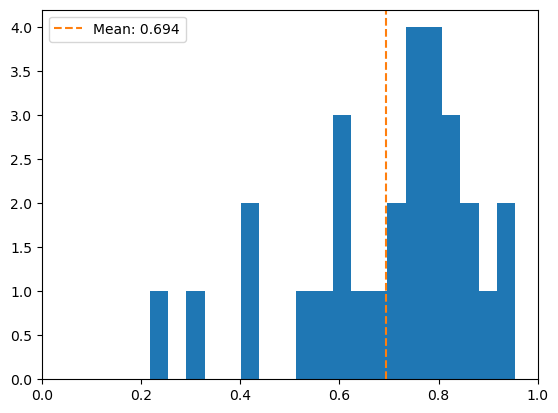

In [25]:
plot_auc_PDF(log_reg_aucs_hybrid)

### Comparision ROC

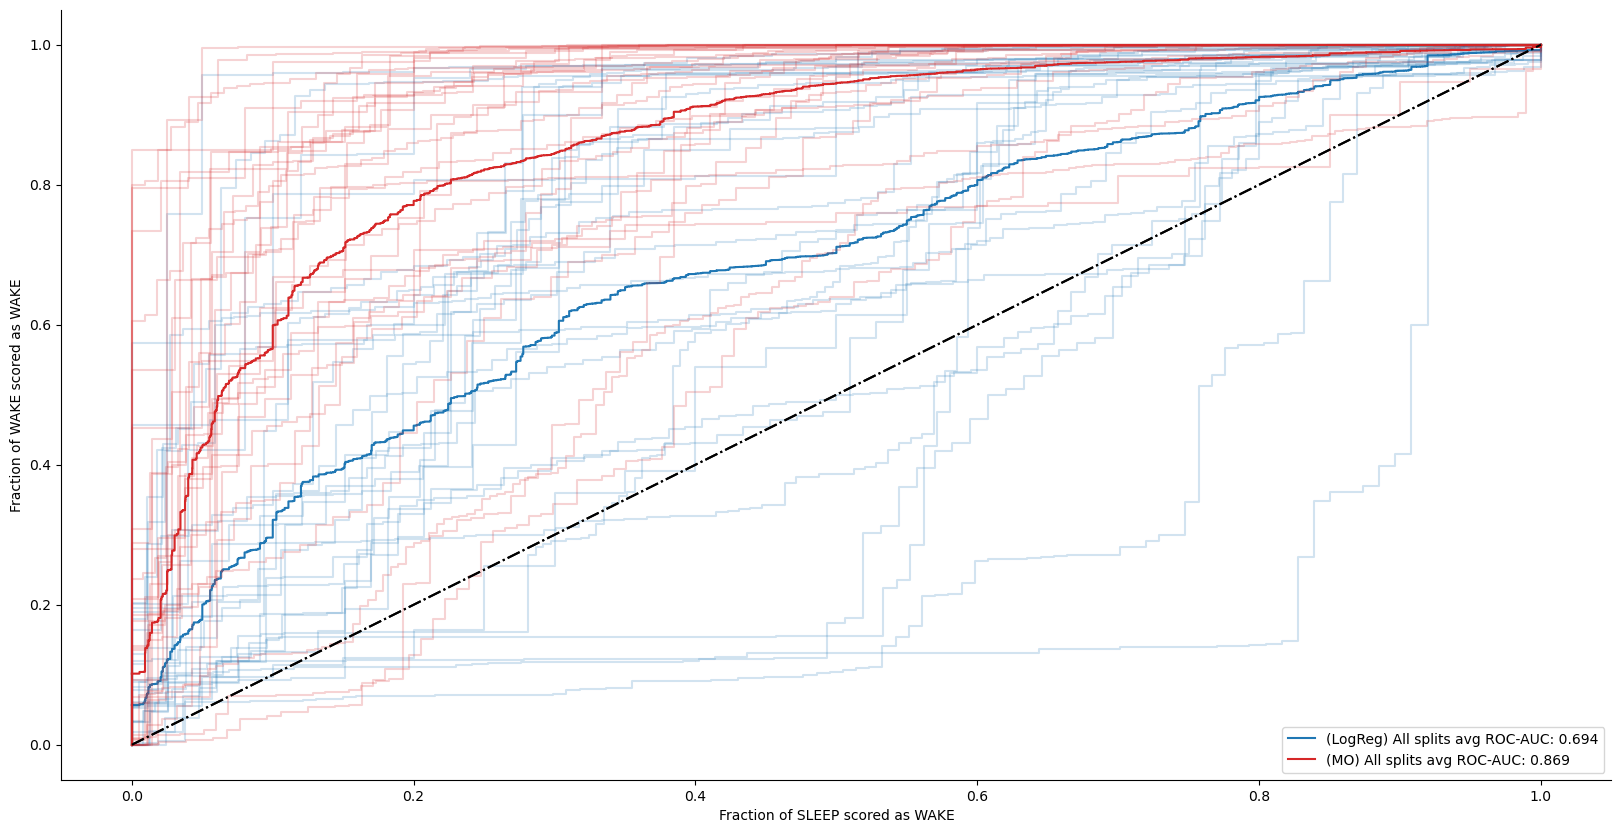

In [26]:


fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    fprs=log_reg_fprs_hybrid,
    tprs=log_reg_tprs_hybrid,
    # min_auc=0.7, 
    avg_curve_color="tab:blue",
    specific_curve_color="tab:blue",
    roc_group_name="(LogReg)",
    ax=ax,
)

add_rocs(
    fprs=mo_fprs_hybrid,
    tprs=mo_tprs_hybrid,
    avg_curve_color="tab:red",
    specific_curve_color="tab:red",
    # min_auc=0.7,
    roc_group_name="(MO)",
    ax=ax
)
ax.legend(loc='lower right')

### Comparision: TST, WASA93